In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install deep-translator tqdm

In [2]:
import pandas as pd
from deep_translator import GoogleTranslator
from tqdm import tqdm
import time
import math

ModuleNotFoundError: No module named 'deep_translator'

## **1️⃣ 포르투갈어 - 영어 번역**

🚨 CPU로 돌릴 시 4시간 소요되니 GPU 사용 강력 권장 !!!

In [ ]:
# olist_order_reviews_dataset.csv 데이터셋 리뷰 제목, 리뷰 내용 포르투갈어 - 영어로 번역

# ===== 사용자 입력 부분 =====
csv_path = '/content/drive/MyDrive/Epoch/olist_order_reviews_dataset.csv'
title_col = 'review_comment_title'   # 리뷰 제목 컬럼
body_col  = 'review_comment_message' # 리뷰 내용 컬럼
out_path  = '/content/drive/MyDrive/Epoch/olist_order_reviews_translated.csv'
# ============================

df = pd.read_csv(csv_path)

translator = GoogleTranslator(source='pt', target='en')

# 간단 캐시(중복 텍스트 재사용)
_cache = {}

def safe_translate(text, retries=3, delay=1.0):
    """NaN/빈값 건너뛰고, 에러 시 재시도. 캐시 사용."""
    if text is None:
        return None
    # 문자열화
    s = str(text).strip()
    # 비어있으면 그대로 반환
    if s == '':
        return s
    # 캐시에 있으면 반환
    if s in _cache:
        return _cache[s]
    # 번역 시도
    last_err = None
    for _ in range(retries):
        try:
            t = translator.translate(s)
            _cache[s] = t
            return t
        except Exception as e:
            last_err = e
            time.sleep(delay)
    # 재시도 후에도 실패하면 원문 반환(원하면 None이나 'ERROR'로 바꿔도 됨)
    _cache[s] = s
    return s

# 존재하는 컬럼만 처리(없는 컬럼은 자동 건너뜀)
if title_col in df.columns:
    tqdm.pandas(desc=f"Translating {title_col}")
    df[title_col + '_en'] = df[title_col].progress_apply(safe_translate)

if body_col in df.columns:
    tqdm.pandas(desc=f"Translating {body_col}")
    df[body_col + '_en'] = df[body_col].progress_apply(safe_translate)

# 저장
df.to_csv(out_path, index=False)
print("Saved to:", out_path)


NameError: name 'pd' is not defined

In [ ]:
# olist_order_reviews_dataset.csv 데이터셋 영어로 된번역본 csv 파일로 저장

# 1) 데이터 로드
reviews = pd.read_csv("/content/drive/MyDrive/Epoch/olist_order_reviews_translated.csv")
final = pd.read_csv("/content/drive/MyDrive/Epoch/진짜진짜진짜최종.csv")

# 2) full outer join (빠지는 것 없이 다 합치기)
merged = pd.merge(
    reviews,
    final,
    on="order_id",
    how="outer"   # outer join으로 빠지는 값 없이 합침
)

# 3) 저장
OUTPUT_PATH = "/content/olist_reviews_joined_final.csv"
merged.to_csv(OUTPUT_PATH, index=False)

print(f"완료! 저장된 파일: {OUTPUT_PATH}")
print(f"최종 행 개수: {len(merged):,}")
print("컬럼:", merged.columns.tolist()[:15], "...")  # 앞부분만 미리보기

In [ ]:
# olist_products_dataset.csv 데이터셋의 카테고리명 영어로 번역하기

# CSV 불러오기 (경로는 본인 드라이브에 맞게 수정)
df_a = pd.read_csv('/content/drive/MyDrive/Epoch/olist_products_dataset.csv')
df_b = pd.read_csv('/content/drive/MyDrive/Epoch/product_category_name_translation.csv')

# 브라질어 → 영어 매핑 딕셔너리 만들기
mapping = dict(zip(df_b['product_category_name'], df_b['product_category_name_english']))

# a-1 컬럼을 영어로 변환
df_a['product_category_name'] = df_a['product_category_name'].map(mapping)

# 결과 확인
print(df_a.head())

# 다시 저장 (필요하다면)
df_a.to_csv('/content/drive/MyDrive/olist_products_dataset_translated.csv', index=False)

## **2️⃣ 테이블 재구성**

재주문율을 구하는 데 있어서 같은 customer_unique_id를 가진 고객이 서로 다른 order_id / customer_id를 가진 경우가 재주문한 케이스일 것으로 판단, table을 customer table을 ‘customer_unique_id’를 기준으로 재구성함

In [4]:
# 원본 로드
df = pd.read_csv('/content/drive/MyDrive/Epoch/olist_customers_dataset.csv')

# 1) 고객별 주문 수 계산해서 병합
counts = df.groupby('customer_unique_id')['customer_id'].count().rename('cnt')
df = df.merge(counts, on='customer_unique_id', how='left')

# 2) 주문 수 기준 내림차순 정렬(동률일 때 보조 정렬은 상황 맞게)
df = df.sort_values(['cnt', 'customer_unique_id', 'customer_id'], ascending=[False, True, True])

# 3) 각 고객 그룹에서 첫 줄만 정보 남기고 나머지는 공란
df['seq'] = df.groupby('customer_unique_id').cumcount()
cols_first_row_only = ['customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']
for c in cols_first_row_only:
    df[c] = df[c].where(df['seq'] == 0, '')

# 4) 최종 컬럼 선택 / 보조 컬럼 제거
out = df[['customer_unique_id', 'customer_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']]
out.to_csv('/content/drive/MyDrive/Epoch/olist_customers_dataset_aligned.csv', index=False)

# 코드 출력 예시 결과 보기
print(out.head(40))

                     customer_unique_id                       customer_id  \
90268  8d50f5eadf50201ccdcedfb9e2ac8455  0bf8bf19944a7f8b40ba86fef778ca7c   
74510                                    0e4fdc084a6b9329ed55d62dcd653ccf   
14186                                    1bd3585471932167ab72a84955ebefea   
52574                                    1c62b48fb34ee043310dcb233caabd2e   
96652                                    31dd055624c66f291578297a551a6cdf   
72745                                    3414a9c813e3ca02504b8be8b2deb27f   
38073                                    42dbc1ad9d560637c9c4c1533746f86d   
67996                                    6289b75219d757a56c0cce8d9e427900   
48614                                    65f9db9dd07a4e79b625effa4c868fcb   
16654                                    897b7f72042714efaa64ac306ba0cafc   
85507                                    89be66634d68fa73a95499b6352e085d   
93591                                    9a1afef458843a022e431f4cb304dfe9   

존재하는 데이터 중 ‘재주문’과 관련된 데이터 column들을 선정: customer_unique_id, customer_id, order_id, product_id, product_category_name를 각각 조인하여 하나의 table로 생성하여 재주문율(or 재주문 고객 수)을 구함. 이때 customer_id & customer_unique_id는 바로 위의 코드를 참고하여 제작함

In [5]:
# 1) 파일 경로/이름
PATH_CUSTOMERS = "/content/drive/MyDrive/Epoch/olist_customers_dataset_aligned.csv"
PATH_ORDERS    = "/content/drive/MyDrive/Epoch/olist_orders_dataset.csv"
PATH_ITEMS     = "/content/drive/MyDrive/Epoch/olist_order_items_dataset.csv"
PATH_PRODUCTS  = "/content/drive/MyDrive/Epoch/olist_products_dataset.csv"
OUTPUT_PATH    = "/content/drive/MyDrive/Epoch/진짜진짜진짜최종.csv"

# 2) 로드: 필요한 컬럼만, 문자열로
customers = pd.read_csv(
    PATH_CUSTOMERS, usecols=["customer_unique_id", "customer_id"], dtype=str
)
orders = pd.read_csv(
    PATH_ORDERS, usecols=["order_id", "customer_id"], dtype=str
)
order_items = pd.read_csv(
    PATH_ITEMS, usecols=["order_id", "product_id"], dtype=str
)
products = pd.read_csv(
    PATH_PRODUCTS, usecols=["product_id", "product_category_name"], dtype=str
)

# 3) 조인 (모두 inner)
cust_orders = customers.merge(orders, on="customer_id", how="inner")
cust_orders_items = cust_orders.merge(order_items, on="order_id", how="inner")
merged = cust_orders_items.merge(products, on="product_id", how="inner")

# 4) 컬럼 정리
final_df = merged[[
    "customer_unique_id",
    "customer_id",
    "order_id",
    "product_id",
    "product_category_name"
]]

# 5) 결측치 제거 (product_category_name 없는 행은 삭제)
final_df = final_df.dropna(subset=["product_category_name"])

# 6) 완전히 동일한 행 중복 제거
final_df = final_df.drop_duplicates()

# customer_unique_id 열에서 NaN을 앞 값으로 채우기
final_df["customer_unique_id"] = final_df["customer_unique_id"].fillna(method="ffill")

# 7) 저장
final_df.to_csv(OUTPUT_PATH, index=False)

print(f"완료! 저장 파일: {OUTPUT_PATH}")
print(f"행 개수: {len(final_df):,}")
print(final_df.head())

/tmp/ipython-input-4093121299.py:43: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_df["customer_unique_id"] = final_df["customer_unique_id"].fillna(method="ffill")


완료! 저장 파일: /content/drive/MyDrive/Epoch/진짜진짜진짜최종.csv
행 개수: 100,943
                 customer_unique_id                       customer_id  \
0  8d50f5eadf50201ccdcedfb9e2ac8455  0bf8bf19944a7f8b40ba86fef778ca7c   
1  8d50f5eadf50201ccdcedfb9e2ac8455  0e4fdc084a6b9329ed55d62dcd653ccf   
2  8d50f5eadf50201ccdcedfb9e2ac8455  1bd3585471932167ab72a84955ebefea   
4  8d50f5eadf50201ccdcedfb9e2ac8455  3414a9c813e3ca02504b8be8b2deb27f   
5  8d50f5eadf50201ccdcedfb9e2ac8455  42dbc1ad9d560637c9c4c1533746f86d   

                           order_id                        product_id  \
0  e3071b7624445af6e4f3a1b23718667d  88159bac10e3d4f4b69b157406c7f70f   
1  5d848f3d93a493c1c8955e018240e7ca  4e1d2ef2974c85d82582edfe594a4f57   
2  b850a16d8faf65a74c51287ef34379ce  5bccc8fe44471df6c7b7e08176837d2f   
4  a1a6eadae352582010f449d8527b55f3  426f910ccd39ae5e7d55013c466fe343   
5  bf92c69b7cc70f7fc2c37de43e366173  e01bc2ad5c6f46c0f53f73379fcd602e   

  product_category_name  
0        sports_leisure  
1  

##**3️⃣ 재주문율 계산**


In [22]:
df = pd.read_csv('/content/drive/MyDrive/Epoch/진짜진짜진짜최종.csv')

In [23]:
# 고객-카테고리별 구매 건수
cust_cat_orders = (
    df.groupby(["customer_unique_id", "product_category_name"])["product_id"]
      .count()
      .reset_index()
      .rename(columns={"product_id": "purchase_count"})
)

# 재구매 여부 (구매 건수 >= 2)
cust_cat_orders["is_repurchase"] = (cust_cat_orders["purchase_count"] >= 2).astype(int)

In [24]:
print(cust_cat_orders["is_repurchase"]==1 )

0        False
1        False
2        False
3        False
4        False
         ...  
96437     True
96438    False
96439    False
96440    False
96441    False
Name: is_repurchase, Length: 96442, dtype: bool


In [25]:
# 카테고리별 재구매 고객 수 계산
category_repurchase = (
    cust_cat_orders.groupby("product_category_name")["is_repurchase"]
      .sum()
      .reset_index()
      .rename(columns={"is_repurchase": "repurchase_count"})
)

In [26]:
# 재구매 고객 많은 순 정렬
category_repurchase.sort_values("repurchase_count", ascending=False).head(10)

,product_category_name,repurchase_count
7,bed_bath_table,815
39,furniture_decor,368
43,health_beauty,311
65,sports_leisure,298
15,computers_accessories,288
70,watches_gifts,208
49,housewares,177
28,fashion_bags_accessories,139
68,telephony,127
5,auto,124


In [27]:
# 낮은 순 정렬 후 확인
category_repurchase.sort_values("repurchase_count", ascending=True).head(10)

,product_category_name,repurchase_count
2,art,0
11,cds_dvds_musicals,0
29,fashion_childrens_clothes,0
22,costruction_tools_tools,0
41,furniture_mattress_and_upholstery,0
35,flowers,0
34,fixed_telephony,0
32,fashion_sport,0
55,music,0
52,la_cuisine,0


### review_comment_message_en 감정 분석

In [30]:
reviews=pd.read_csv('/content/drive/MyDrive/Epoch/olist_reviews_joined_final.csv')
print(reviews)

                               review_id                          order_id  \
0       97ca439bc427b48bc1cd7177abe71365  00010242fe8c5a6d1ba2dd792cb16214   
1       7b07bacd811c4117b742569b04ce3580  00018f77f2f0320c557190d7a144bdd3   
2       0c5b33dea94867d1ac402749e5438e8b  000229ec398224ef6ca0657da4fc703e   
3       f4028d019cb58564807486a6aaf33817  00024acbcdf0a6daa1e931b038114c75   
4       940144190dcba6351888cafa43f3a3a5  00042b26cf59d7ce69dfabb4e55b4fd9   
...                                  ...                               ...   
103699  9185f849f32d82e216a4e025e0c50f5c  fffc94f6ce00a00581880bf54a75a037   
103700  be803f6a93d64719fd685c1cc610918a  fffcd46ef2263f404302a634eb57f7eb   
103701  dbdd81cd59a1a9f94a10a990b4d48dce  fffce4705a9662cd70adb13d4a31832d   
103702  fba117c9ac40d41ca7be54741f471303  fffe18544ffabc95dfada21779c9644f   
103703  b2700869a37f1aafc9dda829dc2f9027  fffe41c64501cc87c801fd61db3f6244   

        review_score review_comment_title  \
0                5

In [31]:
#    str(text)는 혹시 있을지 모를 숫자나 누락값을 문자열로 안전하게 변환합니다.
analyzer = SentimentIntensityAnalyzer()

reviews['sentiment_score'] = reviews['review_comment_message_en'].apply(
    lambda text: analyzer.polarity_scores(str(text))['compound']
)

# 3. 분석 결과 확인
#    새로 생성된 'sentiment_score' 열과 함께 데이터프레임의 일부를 출력해봅니다.
print(reviews[['review_comment_message_en', 'sentiment_score']].head())

                           review_comment_message_en  sentiment_score
0        Perfect, product delivered before combined.           0.5719
1                                                NaN           0.0000
2  It arrived before the scheduled deadline and t...           0.5709
3                                                NaN           0.0000
4                I liked it because it came on time.           0.4215


In [32]:
print(reviews[['review_comment_message_en', 'sentiment_score']].head())

                           review_comment_message_en  sentiment_score
0        Perfect, product delivered before combined.           0.5719
1                                                NaN           0.0000
2  It arrived before the scheduled deadline and t...           0.5709
3                                                NaN           0.0000
4                I liked it because it came on time.           0.4215


In [33]:
print("\n--- VADER 감성 점수 통계 (describe() 결과) ---")
print(reviews['sentiment_score'].describe())


--- VADER 감성 점수 통계 (describe() 결과) ---
count    103704.000000
mean          0.111350
std           0.305043
min          -0.949300
25%           0.000000
50%           0.000000
75%           0.000000
max           0.988600
Name: sentiment_score, dtype: float64


## **4️⃣ VADER 기반 Word Cloud 생성**

In [6]:
!pip uninstall -y numpy scipy
!pip install numpy==2.0.1 scipy==1.14.1
!pip install pandas matplotlib wordcloud

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: scipy 1.16.2
Uninstalling scipy-1.16.2:
  Successfully uninstalled scipy-1.16.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 12.8 MB/s eta 0:00:00


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


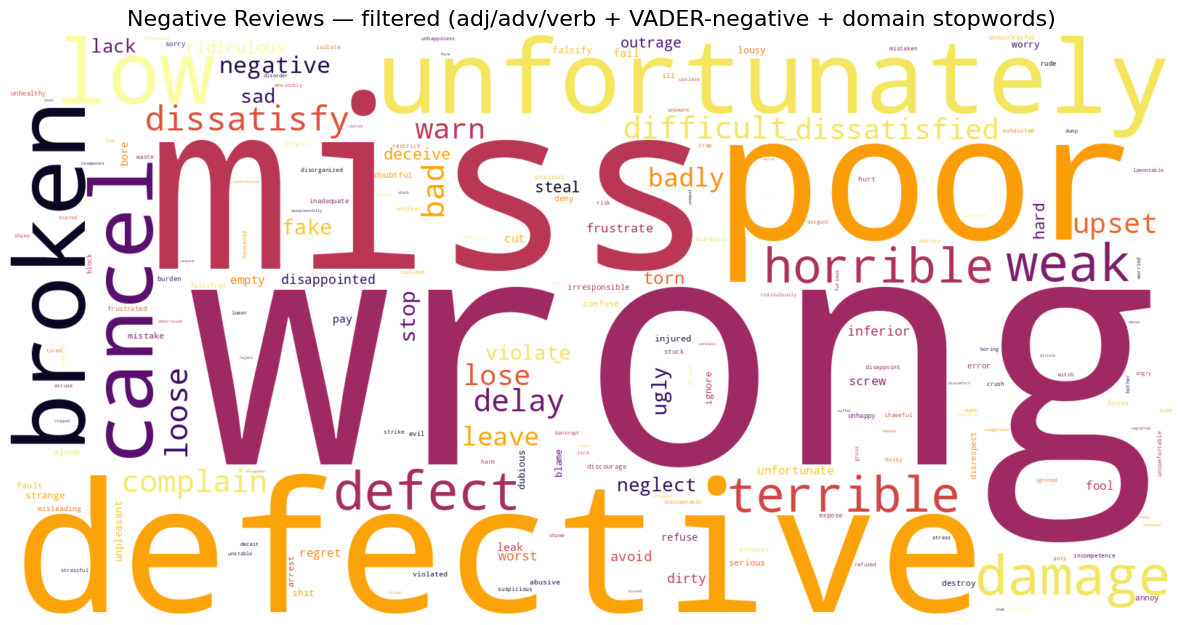

In [7]:
# 전제: pandas, nltk, wordcloud, matplotlib 설치/사용 가능 상태
import re, string
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# 필요한 NLTK 리소스 다운로드 (한 번만)
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

# 1) 데이터 로드
df = pd.read_csv("/content/drive/MyDrive/Epoch/olist_reviews_joined_final.csv")
text_col = "review_comment_message_en"
df[text_col] = df[text_col].astype(str)

# 2) 감성 점수 계산 + 엄격한 부정만 선택
sid = SentimentIntensityAnalyzer()
df["compound"] = df[text_col].map(lambda x: sid.polarity_scores(x)["compound"])
neg_df = df[df["compound"] <= -0.30].copy()   # 임계값 조정 가능

# 3) 전처리 유틸
def nltk_pos_to_wordnet(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    if tag.startswith('V'):
        return wordnet.VERB
    if tag.startswith('N'):
        return wordnet.NOUN
    if tag.startswith('R'):
        return wordnet.ADV
    return wordnet.NOUN

lemmatizer = WordNetLemmatizer()
en_stop = set(stopwords.words('english'))

# 도메인 불용어(중립적/설명적 단어들): 필요시 계속 추가
domain_stop = {
    'product','order','purchase','buy','bought','store','seller','site','online',
    'receive','received','delivered','delivery','arrive','arrived','shipping',
    'package','post','office','time','day','days','month','months','one','two',
    'piece','kit','item','quality','good','bad','recommend','request','exchange',
    'return','returned','pay','paid','price','color','size','model'
}

# 4) 토큰화 → 표제어화 → 품사 필터링 → VADER negative lexicon 필터
def keep_negative_tokens(text):
    # 기본 클린업
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    text = re.sub(r"[\d]", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = [t for t in word_tokenize(text) if len(t) > 2]

    # 불용어/도메인 불용어 제거
    tokens = [t for t in tokens if t not in en_stop and t not in domain_stop]

    # 품사 태깅 후 형용사/부사(+부정적 동사 일부) 위주
    tagged = pos_tag(tokens)
    filtered = []
    for tok, tag in tagged:
        wn_tag = nltk_pos_to_wordnet(tag)
        lemma = lemmatizer.lemmatize(tok, wn_tag)

        # 품사 필터: 형용사, 부사, 동사 위주(명사는 대부분 제거)
        if tag.startswith(('J','R','V')):
            filtered.append(lemma)

    # VADER lexicon 기준으로 부정 점수 단어만 남기기
    neg_only = []
    for w in filtered:
        score = sid.lexicon.get(w, 0.0)  # VADER 사전에 있으면 점수, 없으면 0
        if score < 0:                    # 점수가 음수인 단어만 채택
            neg_only.append(w)
    return neg_only

# 5) 부정 리뷰에서 부정 단어만 모아 빈도 계산
from collections import Counter
neg_words = []
for txt in neg_df[text_col].tolist():
    neg_words.extend(keep_negative_tokens(txt))

freq = Counter(neg_words)

# 6) WordCloud (부정 전용)
wc = WordCloud(
    width=1600, height=800,
    background_color="white",
    colormap="inferno",         # 부정 느낌의 팔레트
    max_words=200
).generate_from_frequencies(freq)

plt.figure(figsize=(15,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews — filtered (adj/adv/verb + VADER-negative + domain stopwords)", fontsize=16)
plt.show()

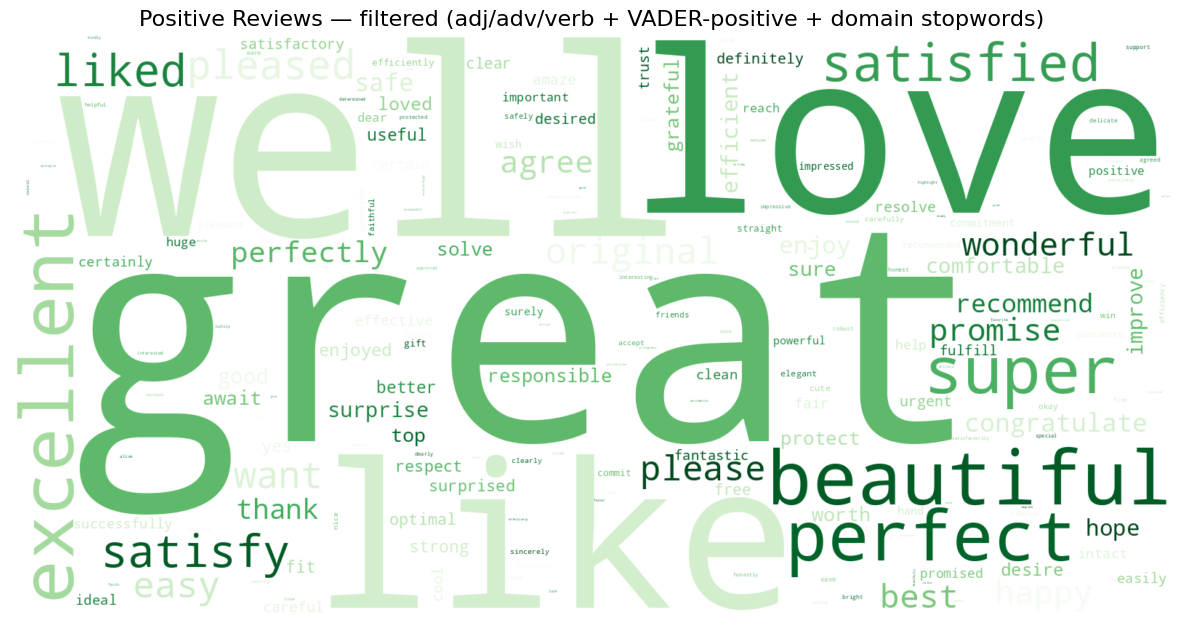

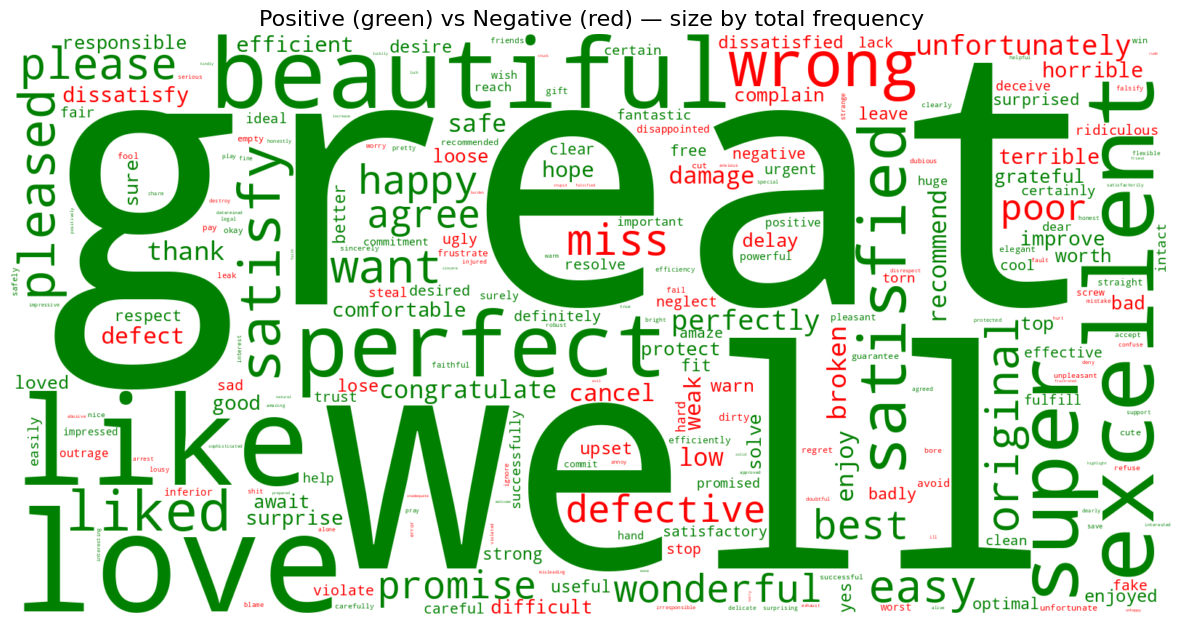

In [8]:
# ---------------------------------------------
# ① 긍정 전용 토큰 필터 (네가 만든 규칙 그대로, 점수만 > 0)
# ---------------------------------------------
def keep_positive_tokens(text):
    # 기본 클린업 (네가 쓰던 것과 동일)
    t = text.lower()
    t = re.sub(r"http\S+|www\.\S+", " ", t)
    t = re.sub(r"[\d]", " ", t)
    t = t.translate(str.maketrans("", "", string.punctuation))
    tokens = [tok for tok in word_tokenize(t) if len(tok) > 2]

    # 불용어/도메인 불용어 제거
    tokens = [tok for tok in tokens if tok not in en_stop and tok not in domain_stop]

    # 품사 태깅 후 형용사/부사/동사 위주
    tagged = pos_tag(tokens)
    filtered = []
    for tok, tag in tagged:
        wn_tag = nltk_pos_to_wordnet(tag)
        lemma = lemmatizer.lemmatize(tok, wn_tag)
        if tag.startswith(('J','R','V')):
            filtered.append(lemma)

    # VADER lexicon에서 양수 점수 단어만 유지
    pos_only = []
    for w in filtered:
        score = sid.lexicon.get(w, 0.0)
        if score > 0:
            pos_only.append(w)
    return pos_only

# ---------------------------------------------
# ② 긍정 리뷰 선택(임계값 엄격) + 빈도 계산
# ---------------------------------------------
pos_df = df[df["compound"] >= 0.30].copy()  # 임계값은 네가 -0.30 쓴 것에 맞춰 +0.30
from collections import Counter

pos_words = []
for txt in pos_df[text_col].tolist():
    pos_words.extend(keep_positive_tokens(txt))
pos_freq = Counter(pos_words)

# 긍정 워드클라우드
wc_pos = WordCloud(
    width=1600, height=800,
    background_color="white",
    colormap="Greens",      # 긍정 느낌
    max_words=200
).generate_from_frequencies(pos_freq)

plt.figure(figsize=(15,8))
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews — filtered (adj/adv/verb + VADER-positive + domain stopwords)", fontsize=16)
plt.show()

# ---------------------------------------------
# ③ 부정 쪽(이미 계산한 neg_words/freq 사용)
#    만약 위에서 변수명이 다르면 neg_freq로 맞춰주세요.
# ---------------------------------------------
neg_freq = freq  # 네가 이미 만든 Counter(neg_words)가 freq 라면 이 줄 유지

# ---------------------------------------------
# ④ 긍·부정 합쳐서: 크기는 '빈도 합'으로, 색상만 감정별
#    - 단어가 양쪽에 모두 있으면 더 큰 쪽의 감정 색으로 칠함
# ---------------------------------------------
# 전체 빈도(양쪽 합) 계산
all_words = set(pos_freq.keys()) | set(neg_freq.keys())
all_freq = {}
sentiment_of_word = {}

for w in all_words:
    p = pos_freq.get(w, 0)
    n = neg_freq.get(w, 0)
    all_freq[w] = p + n
    if p > n:
        sentiment_of_word[w] = "pos"
    elif n > p:
        sentiment_of_word[w] = "neg"
    else:
        # 동률이면 중립 처리 대신 'pos'로 두거나 임의로 한쪽 선택
        sentiment_of_word[w] = "pos"

# 색상 함수: 긍정=녹색, 부정=붉은색
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    if sentiment_of_word.get(word) == "neg":
        return "red"
    else:
        return "green"

wc_all = WordCloud(
    width=1600, height=800,
    background_color="white",
    max_words=250
).generate_from_frequencies(all_freq)

wc_all_colored = wc_all.recolor(color_func=color_func)

plt.figure(figsize=(15,8))
plt.imshow(wc_all_colored, interpolation='bilinear')
plt.axis('off')
plt.title("Positive (green) vs Negative (red) — size by total frequency", fontsize=16)
plt.show()

##**5️⃣ 긍정 vs 부정 리뷰 비교 분석**

In [9]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# =============================
# 1) 데이터 로드
# =============================
df = pd.read_csv("/content/drive/MyDrive/Epoch/olist_reviews_joined_final.csv")

# =============================
# 2) VADER 감성 점수 계산
# =============================
sid = SentimentIntensityAnalyzer()
df["compound"] = df["review_comment_message_en"].dropna().map(
    lambda x: sid.polarity_scores(str(x))["compound"]
)

def sentiment_label(score):
    if score >= 0.3:
        return "positive"
    elif score <= -0.3:
        return "negative"
    else:
        return "neutral"

df["text_sentiment"] = df["compound"].map(sentiment_label)

# =============================
# 3) Review Score vs Text Sentiment 매트릭스
# =============================
crosstab = pd.crosstab(df["review_score"], df["text_sentiment"], normalize="index") * 100
print("별점 vs 텍스트 감성 비율 (%)")
print(crosstab.round(1))

# =============================
# 4) 불일치 케이스 탐색
# =============================
# 예: 별점은 높지만(>=4), 텍스트는 negative
bad_case_highscore = df[(df["review_score"] >= 4) & (df["text_sentiment"] == "negative")]

# 예: 별점은 낮지만(<=2), 텍스트는 positive
bad_case_lowscore = df[(df["review_score"] <= 2) & (df["text_sentiment"] == "positive")]

print("\n별점 높음 + 텍스트 부정 케이스 수:", len(bad_case_highscore))
print("별점 낮음 + 텍스트 긍정 케이스 수:", len(bad_case_lowscore))

# =============================
# 5) 불일치 케이스 리뷰 예시 출력
# =============================
print("\n⭐️ 별점은 높지만 텍스트는 부정적인 리뷰 예시")
print(bad_case_highscore[["review_score", "review_comment_message_en"]].sample(5, random_state=42))

print("\n⭐️ 별점은 낮지만 텍스트는 긍정적인 리뷰 예시")
print(bad_case_lowscore[["review_score", "review_comment_message_en"]].sample(5, random_state=42))

별점 vs 텍스트 감성 비율 (%)
text_sentiment  negative  neutral  positive
review_score                               
1.0                 21.6     69.6       8.8
2.0                 16.8     71.9      11.3
3.0                  7.4     78.5      14.1
4.0                  1.9     79.5      18.6
5.0                  0.5     72.1      27.4

별점 높음 + 텍스트 부정 케이스 수: 654
별점 낮음 + 텍스트 긍정 케이스 수: 1485

⭐️ 별점은 높지만 텍스트는 부정적인 리뷰 예시
       review_score                          review_comment_message_en
53076           4.0  It arrived on time without incidents, exactly ...
10672           5.0  The store is excellent, but the product was ba...
82109           4.0  Not came the glove sent an ugly watch in place...
45737           5.0  It is not very nice because it makes a lot of ...
57466           5.0  Product with the lowest price on the market an...

⭐️ 별점은 낮지만 텍스트는 긍정적인 리뷰 예시
       review_score                          review_comment_message_en
8429            1.0                         Note only I'm favorin

In [10]:
bad_case_highscore.to_csv("/content/review_highscore_but_negative.csv", index=False)
bad_case_lowscore.to_csv("/content/review_lowscore_but_positive.csv", index=False)

In [11]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import re

# 1) 불일치 케이스 불러오기
df_bad = pd.read_csv("/content/review_highscore_but_negative.csv")

# 2) 간단 전처리
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text

df_bad["cleaned"] = df_bad["review_comment_message_en"].map(clean_text)

vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X = vectorizer.fit_transform(df_bad["cleaned"].dropna())

nmf = NMF(n_components=3, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

for i, topic in enumerate(H):
    words = [vectorizer.get_feature_names_out()[j] for j in topic.argsort()[-10:]]
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: purchase, fast, store, bought, deadline, time, right, delivered, recommend, problem
Topic 1: delivery, defect, bought, delivered, received, wrong, arrived, time, came, product
Topic 2: according, remove, trouble, strike, problems, fault, delivery, delay, office, post


In [12]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import re

# 1) 불일치 케이스 불러오기
df_bad = pd.read_csv("/content/review_highscore_but_negative.csv")

# 2) 간단 전처리
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text

df_bad["cleaned"] = df_bad["review_comment_message_en"].map(clean_text)

vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X = vectorizer.fit_transform(df_bad["cleaned"].dropna())

nmf = NMF(n_components=3, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

for i, topic in enumerate(H):
    words = [vectorizer.get_feature_names_out()[j] for j in topic.argsort()[-10:]]
    print(f"Topic {i}: {', '.join(words)}")

Topic 0: purchase, fast, store, bought, deadline, time, right, delivered, recommend, problem
Topic 1: delivery, defect, bought, delivered, received, wrong, arrived, time, came, product
Topic 2: according, remove, trouble, strike, problems, fault, delivery, delay, office, post


In [13]:
# 1) 불일치 케이스 (별점 낮음 + 긍정 텍스트) 불러오기
df_good = pd.read_csv("/content/review_lowscore_but_positive.csv")

# 2) 전처리 (동일)
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text

df_good["cleaned"] = df_good["review_comment_message_en"].map(clean_text)

# 3) TF-IDF 벡터화
vectorizer2 = TfidfVectorizer(max_features=5000, stop_words="english")
X2 = vectorizer2.fit_transform(df_good["cleaned"].dropna())

# 4) NMF 토픽 모델링
nmf2 = NMF(n_components=3, random_state=42)
W2 = nmf2.fit_transform(X2)
H2 = nmf2.components_

# 5) 토픽별 상위 단어 출력
for i, topic in enumerate(H2):
    words = [vectorizer2.get_feature_names_out()[j] for j in topic.argsort()[-10:]]
    print(f"Topic {i}: {', '.join(words)}")


Topic 0: arrived, hope, delivered, receive, time, bought, delivery, did, received, product
Topic 1: curtain, service, night, quality, product, received, havent, afternoon, morning, good
Topic 2: arrived, did, arrive, happened, didnt, product, delivered, receive, know, like


In [14]:
import pandas as pd
import re

# 전처리 함수
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text

# 사유 키워드 사전
delivery_kw = {"delivery","delivered","arrived","delay","shipping","post","office"}
product_kw  = {"product","defect","broken","quality","size","color","fault"}
service_kw  = {"service","support","return","refund","exchange","customer"}

def categorize_reason(text):
    tokens = set(text.split())
    if tokens & delivery_kw:
        return "delivery"
    elif tokens & product_kw:
        return "product"
    elif tokens & service_kw:
        return "service"
    else:
        return "other"

# 불일치 케이스 로드
high_neg = pd.read_csv("/content/review_highscore_but_negative.csv")
low_pos  = pd.read_csv("/content/review_lowscore_but_positive.csv")

# 전처리 + 카테고리 분류
high_neg["cleaned"] = high_neg["review_comment_message_en"].map(clean_text)
low_pos["cleaned"]  = low_pos["review_comment_message_en"].map(clean_text)

high_neg["reason"] = high_neg["cleaned"].map(categorize_reason)
low_pos["reason"]  = low_pos["cleaned"].map(categorize_reason)

# 비율 계산
high_reason = high_neg["reason"].value_counts(normalize=True) * 100
low_reason  = low_pos["reason"].value_counts(normalize=True) * 100

print("⭐️ 별점 높음 + 텍스트 부정 (사유 비율 %)")
print(high_reason.round(1))
print("\n⭐️ 별점 낮음 + 텍스트 긍정 (사유 비율 %)")
print(low_reason.round(1))

⭐️ 별점 높음 + 텍스트 부정 (사유 비율 %)
reason
delivery    43.9
other       31.5
product     23.4
service      1.2
Name: proportion, dtype: float64

⭐️ 별점 낮음 + 텍스트 긍정 (사유 비율 %)
reason
delivery    35.6
other       31.9
product     28.1
service      4.3
Name: proportion, dtype: float64


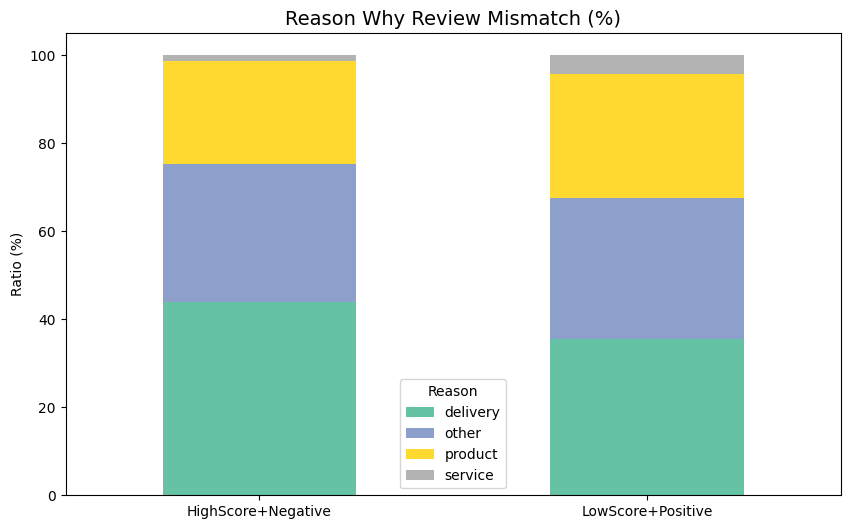

In [15]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# 전처리 함수
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    return text

# 사유 키워드 사전
delivery_kw = {"delivery","delivered","arrived","delay","shipping","post","office"}
product_kw  = {"product","defect","broken","quality","size","color","fault"}
service_kw  = {"service","support","return","refund","exchange","customer"}

def categorize_reason(text):
    tokens = set(text.split())
    if tokens & delivery_kw:
        return "delivery"
    elif tokens & product_kw:
        return "product"
    elif tokens & service_kw:
        return "service"
    else:
        return "other"

# 데이터 불러오기
high_neg = pd.read_csv("/content/review_highscore_but_negative.csv")
low_pos  = pd.read_csv("/content/review_lowscore_but_positive.csv")

# 전처리 + 카테고리 분류
high_neg["cleaned"] = high_neg["review_comment_message_en"].map(clean_text)
low_pos["cleaned"]  = low_pos["review_comment_message_en"].map(clean_text)

high_neg["reason"] = high_neg["cleaned"].map(categorize_reason)
low_pos["reason"]  = low_pos["cleaned"].map(categorize_reason)

# 비율 계산
high_reason = high_neg["reason"].value_counts(normalize=True) * 100
low_reason  = low_pos["reason"].value_counts(normalize=True) * 100

# 두 그룹 합쳐서 DataFrame
compare_df = pd.DataFrame({
    "HighScore+Negative": high_reason,
    "LowScore+Positive": low_reason
}).fillna(0)

# 그래프 그리기
compare_df.T.plot(kind="bar", stacked=True, figsize=(10,6), colormap="Set2")
plt.title("Reason Why Review Mismatch (%)", fontsize=14)
plt.ylabel("Ratio (%)")
plt.xticks(rotation=0)
plt.legend(title="Reason")
plt.show()